In [1]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function, division
%matplotlib inline

# Galaxy Circularity

Here I calculate the circularity for stellar particles in Illustris Galaxies.  Circularity is defined as:

$\epsilon = \frac{j_z}{j_{\rm circ}}$

where,
 
$j_{\rm circ} = r\sqrt{\frac{GM(<r)}{r}}$

and $j_z$ is the component of the angular momentum aligned with the $\vec{L}_{\rm gal}$, the collective specific angular monenutm of star particles in the galaxy.   

## Choose Galaxy

In [2]:
# specify simulation
simname = 'Illustris-1'
snapNum = 135

# load simulation information
from Illustris_Shapes.simulation_props import sim_prop_dict
d = sim_prop_dict[simname]
basePath = d['basePath']
Lbox = d['Lbox']

In [3]:
# load shape catalog
from astropy.table import Table
fname = simname + '_' + str(snapNum) + '_' + 'reduced' + '_' +'galaxy_shapes'+ '.dat' 
t_1 = Table.read('../data/shape_catalogs/'+fname, format='ascii')
t_1['gal_id']

# choose a galaxy
i = 3
gal_id = t_1['gal_id'][i]

## Calculate Circularity

In [4]:
from Illustris_Shapes.calculate_galaxy_circularity import format_velocities, galaxy_selection, galaxy_center
from Illustris_Shapes.calculate_galaxy_circularity import particle_selection, format_particles
from Illustris_Shapes.calculate_galaxy_circularity import specific_angular_momentum, circularity

from illustris_python.snapshot import loadHalo, snapPath, loadSubhalo
from illustris_python.groupcat import gcPath, loadHalos, loadSubhalos, loadHeader

In [6]:
# load galaxy table
fields = ['SubhaloGrNr', 'SubhaloMassInRadType', 'SubhaloPos', 'SubhaloHalfmassRadType']
galaxy_table = loadSubhalos(basePath, snapNum, fields=fields)

In [9]:
# choose a 'center' for each galaxy
gal_position = galaxy_center(gal_id, galaxy_table)

# load stellar particle positions and masses
ptcl_coords = loadSubhalo(basePath, snapNum, gal_id, 4, fields=['Coordinates'])/1000.0
ptcl_vels = loadSubhalo(basePath, snapNum, gal_id, 4, fields=['Velocities'])
ptcl_masses = loadSubhalo(basePath, snapNum, gal_id, 4, fields=['Masses'])*10.0**10

# center and account for PBCs
ptcl_coords = format_particles(gal_position, ptcl_coords, Lbox)

# use center of mass velocity to subtract bulk velocity
ptcl_vels = format_velocities(ptcl_vels, ptcl_masses, basePath, snapNum)

ptcl_mask = particle_selection(gal_id, ptcl_coords, galaxy_table, basePath, snapNum, radial_mask=True, num_r_half=2)

# specific angular momentum of the system
L = specific_angular_momentum(ptcl_coords[ptcl_mask], ptcl_vels[ptcl_mask], ptcl_masses[ptcl_mask])

# try using a random spin axis
#from rotations.mcrotations import random_unit_vectors_3d
#L = random_unit_vectors_3d(1)[0]

epsilon = circularity(ptcl_coords[ptcl_mask], ptcl_vels[ptcl_mask], ptcl_masses[ptcl_mask], L)

## plot circularity

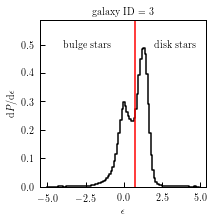

In [10]:
e_thresh = 0.7

bins = np.linspace(-5,5,100)
counts = np.histogram(epsilon, bins=bins, weights=ptcl_masses[ptcl_mask])[0]
counts = 1.0*counts/np.sum(ptcl_masses)/np.diff(bins)
    
fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.title('galaxy ID = ' + str(gal_id))
plt.step(bins[:-1], counts, color='black', where='post')
plt.plot([e_thresh,e_thresh], [0,1.2*np.max(counts)], '-', color='red')
plt.ylim([0,1.2*np.max(counts)])
plt.ylabel(r'${\mathrm d}P/{\mathrm d}\epsilon$')
plt.xlabel(r'$\epsilon$')
plt.text(2,np.max(counts),'disk stars')
plt.text(-4,np.max(counts),'bulge stars')
plt.show()

In [11]:
mask = (epsilon>=0.7)

f_disk = np.sum(ptcl_masses[ptcl_mask][mask])/np.sum(ptcl_masses[ptcl_mask])
print("fraction of stellar mass in disk: ", f_disk)

fraction of stellar mass in disk:  0.5560065
